Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

doga-MSISSD_khs_dir = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery
doga-MSISSD_data_path = /mnt/USB_HDD_1TB/Datasets
doga-MSISSD_experiment_path = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH


In [3]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
EXPERIMENT_ID = 12
LOSS_TYPE='kl'
LOSS_REDUCTION='sum' #'batchmean','mean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [5]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [6]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 1.0  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda:0


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_dgmsissd :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_dgmsissd :: 
EXPERIMENT_ID:  12
LOSS_TYPE :  kl
LOSS_REDUCTION :  sum
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - kl tensor(0.0038, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: 0.003789186477661133

       acc    bmx  bmn      mse    spr      run
0  19.185  0.271  0.0  210.802  1.019  211.821
ValEpoch(000) - 
      acc    bmx  bmn     run
0  23.47  0.129  0.0  30.946
*****
 Epoch 1 of 100
TrEpoch(001) - 
       acc    bmx  bmn      mse   spr      run
0  24.273  0.316  0.0  152.933  0.89  153.823
ValEpoch(001) - 
     acc    bmx  bmn     run
0  24.8  0.146  0.0  21.242
*****
 Epoch 2 of 100
TrEpoch(002) - 
      acc    bmx  bmn      mse    spr      run
0  27.74  0.147  0.0  118.768  0.602  119.369
ValEpoch(002) - 
      acc    bmx  bmn     run
0  36.64  0.113  0.0  18.833
*****
 Epoch 3 of 100
TrEpoch(003) - 
       acc    bmx  bmn      mse    spr     run
0  30.317  0.118  0.0  109.662  0.


       acc    bmx  bmn     mse    spr    run
0  42.955  0.127  0.0  65.074  0.276  65.35
ValEpoch(036) - 
     acc   bmx  bmn     run
0  41.5  0.11  0.0  10.971
*****
 Epoch 37 of 100
TrEpoch(037) - 
       acc   bmx  bmn     mse    spr     run
0  43.688  0.12  0.0  64.667  0.268  64.935
ValEpoch(037) - 
      acc    bmx  bmn     run
0  36.76  0.108  0.0  10.768
*****
 Epoch 38 of 100
TrEpoch(038) - 
       acc    bmx  bmn     mse    spr     run
0  39.952  0.119  0.0  63.859  0.263  64.122
ValEpoch(038) - 
      acc   bmx  bmn    run
0  40.66  0.11  0.0  10.72
*****
 Epoch 39 of 100
TrEpoch(039) - 
       acc    bmx  bmn     mse   spr     run
0  38.108  0.119  0.0  63.603  0.26  63.863
ValEpoch(039) - 
      acc   bmx  bmn     run
0  44.17  0.11  0.0  10.593
*****
 Epoch 40 of 100
TrEpoch(040) - 
       acc    bmx  bmn     mse   spr     run
0  33.775  0.125  0.0  62.366  0.26  62.626
ValEpoch(040) - 
      acc    bmx  bmn     run
0  43.09  0.109  0.0  10.457
*****
 Epoch 41 of 100
TrE

ValEpoch(073) - 
      acc    bmx  bmn    run
0  41.47  0.088  0.0  9.097
*****
 Epoch 74 of 100
TrEpoch(074) - 
      acc    bmx  bmn     mse    spr     run
0  43.39  0.096  0.0  53.339  0.214  53.554
ValEpoch(074) - 
      acc    bmx  bmn    run
0  41.86  0.088  0.0  8.997
*****
 Epoch 75 of 100
TrEpoch(075) - 
       acc    bmx  bmn     mse   spr     run
0  36.927  0.091  0.0  53.275  0.21  53.486
ValEpoch(075) - 
      acc    bmx  bmn    run
0  41.57  0.087  0.0  8.986
*****
 Epoch 76 of 100
TrEpoch(076) - kl tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: 0.00010385364294052124

       acc    bmx  bmn     mse    spr     run
0  42.478  0.092  0.0  53.109  0.209  53.318
ValEpoch(076) - 
      acc    bmx  bmn    run
0  41.47  0.087  0.0  8.955
*****
 Epoch 77 of 100
TrEpoch(077) - 
       acc    bmx  bmn     mse    spr     run
0  42.753  0.095  0.0  52.983  0.207  53.189
ValEpoch(077) - 
      acc    bmx  bmn    run
0  41.74  0.084  0.0  8.948
*****
 Epoch 78 of 100


In [17]:
print(result_df_tr_all)

       acc    bmx  bmn      mse    spr      run
0   19.185  0.271  0.0  210.802  1.019  211.821
1   24.273  0.316  0.0  152.933  0.890  153.823
2   27.740  0.147  0.0  118.768  0.602  119.369
3   30.317  0.118  0.0  109.662  0.478  110.140
4   32.035  0.113  0.0  106.216  0.435  106.651
5   30.347  0.150  0.0  102.719  0.421  103.140
6   34.652  0.181  0.0   99.065  0.415   99.480
7   35.775  0.189  0.0   94.670  0.415   95.085
8   35.303  0.183  0.0   92.908  0.433   93.340
9   39.583  0.194  0.0   91.649  0.470   92.119
10  35.967  0.236  0.0   89.965  0.539   90.504
11  37.367  0.289  0.0   88.017  0.619   88.636
12  36.102  0.282  0.0   86.718  0.624   87.342
13  32.965  0.269  0.0   85.116  0.597   85.713
14  37.093  0.234  0.0   83.163  0.527   83.690
15  34.137  0.244  0.0   81.390  0.481   81.871
16  37.802  0.194  0.0   79.929  0.444   80.373
17  38.508  0.185  0.0   79.349  0.419   79.768
18  37.235  0.177  0.0   77.888  0.395   78.283
19  36.605  0.168  0.0   77.074  0.378  

In [18]:
print(result_df_va_all)

      acc    bmx  bmn     run
0   23.47  0.129  0.0  30.946
1   24.80  0.146  0.0  21.242
2   36.64  0.113  0.0  18.833
3   35.92  0.107  0.0  17.963
4   32.79  0.113  0.0  17.329
5   40.06  0.148  0.0  16.833
6   38.35  0.166  0.0  16.109
7   41.48  0.166  0.0  15.624
8   43.26  0.186  0.0  15.429
9   39.81  0.173  0.0  15.215
10  37.68  0.225  0.0  14.874
11  39.23  0.241  0.0  14.580
12  35.39  0.225  0.0  14.357
13  38.41  0.206  0.0  14.046
14  38.62  0.199  0.0  13.803
15  37.89  0.182  0.0  13.544
16  38.25  0.153  0.0  13.311
17  39.41  0.143  0.0  13.247
18  36.81  0.131  0.0  12.944
19  41.16  0.128  0.0  12.891
20  37.04  0.122  0.0  12.674
21  37.73  0.137  0.0  12.549
22  36.09  0.127  0.0  12.313
23  30.41  0.128  0.0  12.194
24  36.33  0.121  0.0  12.098
25  39.35  0.127  0.0  12.036
26  38.81  0.117  0.0  11.784
27  40.08  0.118  0.0  11.562
28  40.92  0.130  0.0  11.517
29  40.55  0.117  0.0  11.403
30  40.57  0.119  0.0  11.091
31  42.27  0.114  0.0  11.036
32  38.78 

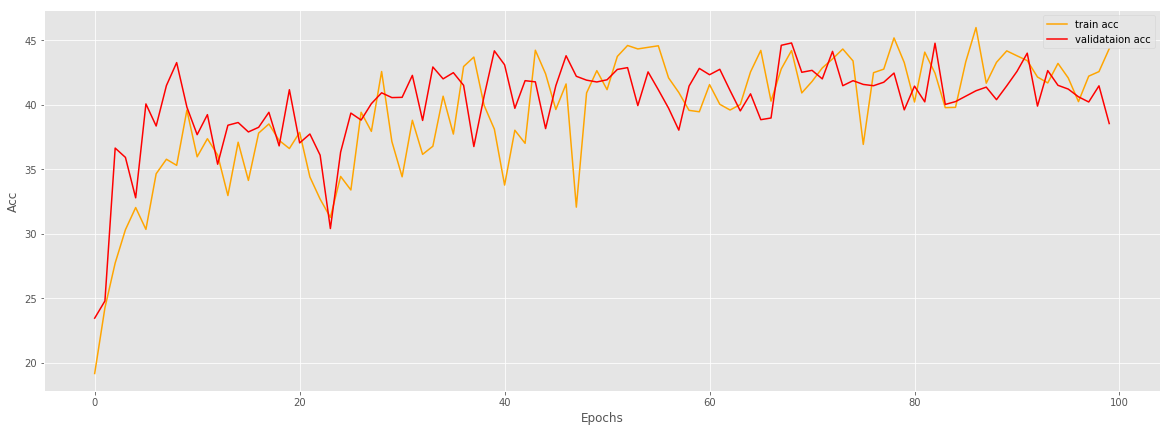

Max tr acc =  45.971666666666664
Max va acc =  44.78


In [41]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

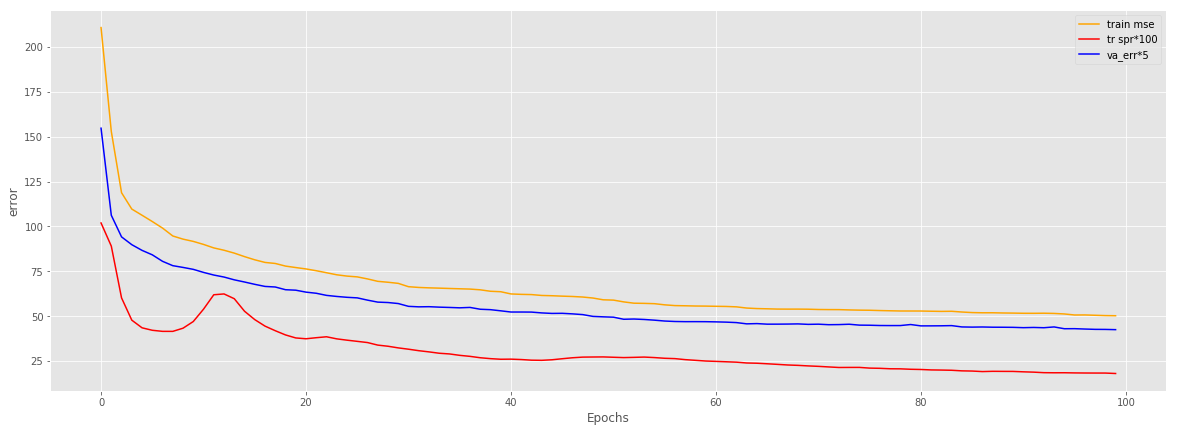

In [40]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 100*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*100')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()